In [55]:
from tdc.multi_pred import DDI
from tdc.utils import get_label_map
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import os
import pickle

In [56]:
config = {
    "dataset":{
        "dataset_bank":{
            'DrugBank':DDI(name = 'DrugBank'),
            'TWOSIDES':DDI(name = 'TWOSIDES')
        },
    },
    
    "metadata":{
        "sel_labels":{
        },
        
        "label_map":{  
            'DrugBank':get_label_map(name = 'DrugBank', task = 'DDI'),
            'TWOSIDES':get_label_map(name = 'TWOSIDES', task = 'DDI', name_column = 'Side Effect Name')
        },
    },
    
}

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


### Dataset slits

In [57]:
for n in tqdm(config["dataset"]["dataset_bank"].keys()):
    config["dataset"]["dataset_bank"][n] = config["dataset"]["dataset_bank"][n].get_split()
    config["dataset"]["dataset_bank"][n]["train"]["ds_name"] = n
    config["dataset"]["dataset_bank"][n]["valid"]["ds_name"] = n
    config["dataset"]["dataset_bank"][n]["test"]["ds_name"] = n
    print("{} : columns - {}, shape - {}".format(
        n,
        config["dataset"]["dataset_bank"][n]["train"].columns, 
        config["dataset"]["dataset_bank"][n]["train"].shape)
          )
    

  0%|          | 0/2 [00:00<?, ?it/s]

DrugBank : columns - Index(['Drug1_ID', 'Drug1', 'Drug2_ID', 'Drug2', 'Y', 'ds_name'], dtype='object'), shape - (134265, 6)


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

TWOSIDES : columns - Index(['Drug1_ID', 'Drug1', 'Drug2_ID', 'Drug2', 'Y', 'ds_name'], dtype='object'), shape - (3254609, 6)


In [58]:
config['dataset']['dataset_bank']['DrugBank']["train"].columns, config['dataset']['dataset_bank']['TWOSIDES']["train"].columns

(Index(['Drug1_ID', 'Drug1', 'Drug2_ID', 'Drug2', 'Y', 'ds_name'], dtype='object'),
 Index(['Drug1_ID', 'Drug1', 'Drug2_ID', 'Drug2', 'Y', 'ds_name'], dtype='object'))

In [59]:
config['metadata']['label_map']['DrugBank'].keys().__len__(), config['metadata']['label_map']['TWOSIDES'].keys().__len__()

(86, 1317)

In [60]:
config['metadata']['label_map']['DrugBank'].values()

dict_values(['#Drug1 may increase the photosensitizing activities of #Drug2.', '#Drug1 may increase the anticholinergic activities of #Drug2.', 'The bioavailability of #Drug2 can be decreased when combined with #Drug1.', 'The metabolism of #Drug2 can be increased when combined with #Drug1.', '#Drug1 may decrease the vasoconstricting activities of #Drug2.', '#Drug1 may increase the anticoagulant activities of #Drug2.', '#Drug1 may increase the ototoxic activities of #Drug2.', 'The therapeutic efficacy of #Drug2 can be increased when used in combination with #Drug1.', '#Drug1 may increase the hypoglycemic activities of #Drug2.', '#Drug1 may increase the antihypertensive activities of #Drug2.', 'The serum concentration of the active metabolites of #Drug2 can be reduced when #Drug2 is used in combination with #Drug1 resulting in a loss in efficacy.', '#Drug1 may decrease the anticoagulant activities of #Drug2.', 'The absorption of #Drug2 can be decreased when combined with #Drug1.', '#Drug

In [61]:
config['metadata']['label_map']['TWOSIDES'].values()

dict_values(['hypermagnesemia', 'retinopathy of prematurity', 'atelectasis', 'alkalosis', 'Back Ache', 'lung edema', 'agitated', 'abnormal movements', 'Acidosis', 'peliosis', 'rupture of spleen', 'Apnea', 'Drug hypersensitivity', 'flatulence', 'pain in throat', 'allergies', 'thrombocytopenia', 'bradycardia', 'lung infiltration', 'Bleeding', 'hypoglycaemia neonatal', 'Gastrointestinal Obstruction', 'hyperglycaemia', 'peritonitis', 'hypoglycaemia', 'abdominal distension', 'asystole', 'cerebral infarct', 'hypoxia', 'Difficulty breathing', 'decreased body temperature', 'adynamic ileus', 'sepsis', 'Hypomagnesaemia', 'neonatal respiratory distress syndrome', 'Acute Respiratory Distress Syndrome', 'lipoma', 'pelvic infection', 'appendectomy', 'flank pain', 'pneumothorax', 'appendicitis', 'Strabismus', 'Blood calcium decreased', 'respiratory failure', 'pulmonary hypertension', 'Hypercapnia', 'intestinal perforation', 'leucocytosis', 'Disorder Lung', 'hot flash', 'arterial pressure NOS decrease

Since these labels suggest that 'TWOSIDES' denotes whether a external side effect exist while 'DrugBank' denotes the existance of a effect on the drug with the current medication both will be considered as seperate models

(18,) 0.9212974341786765 123698.0 673.0


<Axes: xlabel='Y'>

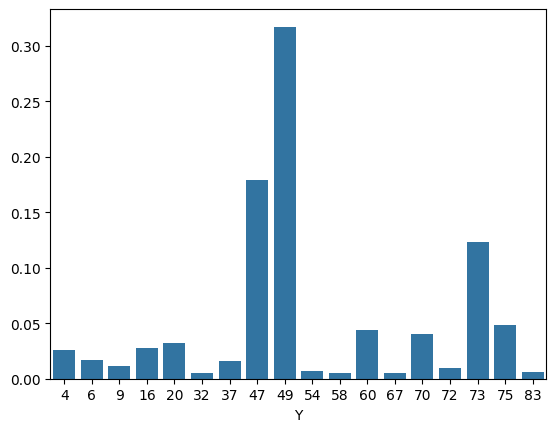

In [62]:
label_dist = config['dataset']['dataset_bank']['DrugBank']["train"]["Y"].value_counts().sort_values(ascending=False)
total_data = label_dist.sum()
label_dist = label_dist/total_data
label_dist = label_dist[label_dist>0.005]
print(label_dist.shape, label_dist.sum(), label_dist.sum()*total_data, label_dist.min()*total_data)
config["metadata"]["sel_labels"]["DrugBank"] = label_dist.index.tolist()
#bargraph of label distribution
sns.barplot(x=label_dist.index, y=label_dist.values)

(26,) 0.12309896519059585 400638.99999999994 13062.0


<Axes: xlabel='Y'>

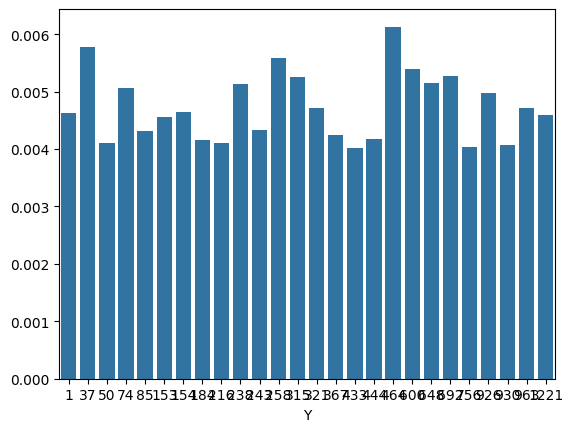

In [63]:
label_dist = config['dataset']['dataset_bank']['TWOSIDES']["train"]["Y"].value_counts().sort_values(ascending=False)
total_data = label_dist.sum()
label_dist = label_dist/total_data
label_dist = label_dist[label_dist>0.004]
print(label_dist.shape, label_dist.sum(), label_dist.sum()*total_data, label_dist.min()*total_data)
config["metadata"]["sel_labels"]["TWOSIDES"] = label_dist.index.tolist()
#bargraph of label distribution
sns.barplot(x=label_dist.index, y=label_dist.values)

In [64]:
config["dataset"]["dataset_bank"]["DrugBank"]["train"] = config["dataset"]["dataset_bank"]["DrugBank"]["train"].loc[config["dataset"]["dataset_bank"]["DrugBank"]["train"]["Y"].isin(config["metadata"]["sel_labels"]["DrugBank"])]
config["dataset"]["dataset_bank"]["DrugBank"]["valid"] = config["dataset"]["dataset_bank"]["DrugBank"]["valid"].loc[config["dataset"]["dataset_bank"]["DrugBank"]["valid"]["Y"].isin(config["metadata"]["sel_labels"]["DrugBank"])]
config["dataset"]["dataset_bank"]["DrugBank"]["test"] = config["dataset"]["dataset_bank"]["DrugBank"]["test"].loc[config["dataset"]["dataset_bank"]["DrugBank"]["test"]["Y"].isin(config["metadata"]["sel_labels"]["DrugBank"])]

config["dataset"]["dataset_bank"]["TWOSIDES"]["train"] = config["dataset"]["dataset_bank"]["TWOSIDES"]["train"].loc[config["dataset"]["dataset_bank"]["TWOSIDES"]["train"]["Y"].isin(config["metadata"]["sel_labels"]["TWOSIDES"])]
config["dataset"]["dataset_bank"]["TWOSIDES"]["valid"] = config["dataset"]["dataset_bank"]["TWOSIDES"]["valid"].loc[config["dataset"]["dataset_bank"]["TWOSIDES"]["valid"]["Y"].isin(config["metadata"]["sel_labels"]["TWOSIDES"])]
config["dataset"]["dataset_bank"]["TWOSIDES"]["test"] = config["dataset"]["dataset_bank"]["TWOSIDES"]["test"].loc[config["dataset"]["dataset_bank"]["TWOSIDES"]["test"]["Y"].isin(config["metadata"]["sel_labels"]["TWOSIDES"])]

In [65]:
train_dataset = pd.concat([d["train"] for d in tqdm(config["dataset"]["dataset_bank"].values())])
valid_dataset = pd.concat([d["valid"] for d in tqdm(config["dataset"]["dataset_bank"].values())])
test_dataset = pd.concat([d["test"] for d in tqdm(config["dataset"]["dataset_bank"].values())])

100%|██████████| 2/2 [00:00<00:00, 74235.47it/s]


In [66]:
train_dataset = train_dataset.groupby(["Drug1", "Drug2", "ds_name"]).agg({
    'Drug1_ID': list,
    'Y': list,
    'Drug2_ID': list
}).reset_index()

valid_dataset = valid_dataset.groupby(["Drug1", "Drug2", "ds_name"]).agg({
    'Drug1_ID': list,
    'Y': list,
    'Drug2_ID': list
}).reset_index()

test_dataset = test_dataset.groupby(["Drug1", "Drug2", "ds_name"]).agg({
    'Drug1_ID': list,
    'Y': list,
    'Drug2_ID': list
}).reset_index()

In [67]:
train_dataset.head()

,Drug1,Drug2,ds_name,Drug1_ID,Y,Drug2_ID
0,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,C(C1C(C(C(C(O1)OC2(C(C(C(O2)OS(=O)(=O)O)OS(=O)...,TWOSIDES,"[CID000093860, CID000093860, CID000093860, CID...","[85, 37, 153, 600, 315, 692, 433, 243, 74, 238...","[CID006398525, CID006398525, CID006398525, CID..."
1,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,C(N)(N)(Cl)Cl,TWOSIDES,"[CID000093860, CID000093860, CID000093860, CID...","[85, 321, 444, 600, 756, 692, 315, 1221, 1, 15...","[CID005311048, CID005311048, CID005311048, CID..."
2,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,C1=CC(=CC=C1C2C(C(=O)N2C3=CC=C(C=C3)F)CCC(C4=C...,TWOSIDES,"[CID000093860, CID000093860, CID000093860, CID...","[216, 243, 153, 756, 315, 238, 600, 963, 464]","[CID000150311, CID000150311, CID000150311, CID..."
3,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,C1C2CNCC1C3=CC4=NC=CN=C4C=C23,TWOSIDES,"[CID000093860, CID000093860, CID000093860, CID...","[648, 85, 74, 50, 258]","[CID000170361, CID000170361, CID000170361, CID..."
4,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,C1CC(=O)NC(=O)C1N2CC3=C(C2=O)C=CC=C3N,TWOSIDES,"[CID000093860, CID000093860, CID000093860, CID...","[85, 321, 315, 37, 756, 50, 367]","[CID000216326, CID000216326, CID000216326, CID..."


In [68]:
train_dataset.shape, train_dataset["ds_name"].value_counts()

((184736, 6),
 ds_name
 DrugBank    123570
 TWOSIDES     61166
 Name: count, dtype: int64)

<Axes: xlabel='Y'>

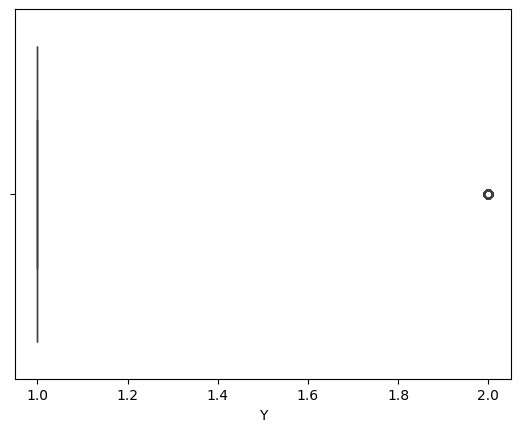

In [69]:
#draw a violin plot of the distributions of the len of the lists in "Y" column of train_dataset where ds_name = "DrugBank"
sns.boxplot(x=train_dataset.loc[train_dataset["ds_name"]=="DrugBank"]["Y"].apply(lambda x: len(x)))

<Axes: xlabel='Y'>

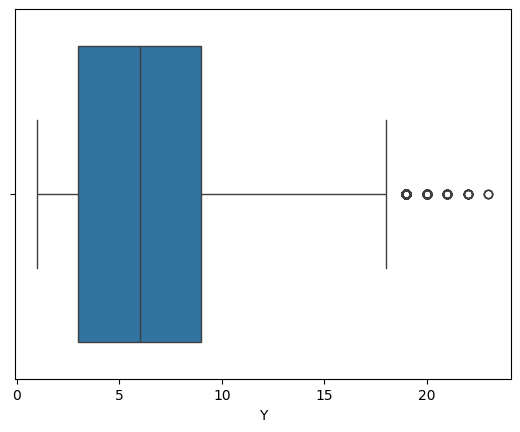

In [70]:
#draw a violin plot of the distributions of the len of the lists in "Y" column of train_dataset where ds_name = "DrugBank"
sns.boxplot(x=train_dataset.loc[train_dataset["ds_name"]=="TWOSIDES"]["Y"].apply(lambda x: len(x)))

In [71]:
### Individual Data Analysis

In [72]:
processed_dir = "processed_data"
os.makedirs(processed_dir, exist_ok=True)
train_dataset.to_csv(f"{processed_dir}/train.csv", index=False)
valid_dataset.to_csv(f"{processed_dir}/valid.csv", index=False)
test_dataset.to_csv(f"{processed_dir}/test.csv", index=False)

with open(f"{processed_dir}/config.pkl", "wb") as f:
    pickle.dump(config["metadata"], f)
